# Data Preperation for Band Contrast Image
- Data being used int he original Band Contrast image found in the BC_Raw_Image folder as well as it's manual annotated mask
- Creating cropped imgaes of the Band Contrast image and its corresponding masks
- Currently crops are being used with dimensions 256 x 256 but this can be adjusted accordingly, smaller dimensions may be advantageous for the model.
- Current image enhancements are HE as well as contrast enhancement, Chambolle has been tested but sigma values remain inconclusive to keep from edges being too blurred to see benefit in this filter.
---


# Mount Drive & import dependencies

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import io, color, exposure, morphology, segmentation, img_as_float, restoration
from skimage.filters import median, threshold_otsu, sobel, gaussian
from skimage.morphology import binary_closing, binary_dilation, remove_small_objects, disk
from skimage.color import rgb2gray
from skimage.segmentation import slic, mark_boundaries

# Import Full Band Contrast image
- **IMPORTATNT NOTE:** If your data is in a different directory structure update as needed
---


In [10]:
# Load the images
original_BC_path = '/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/DataCollection/BC_Raw_Image/band_image.tif'
mask_BC_path = '/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/DataCollection/BC_Raw_Image/mask_band_image.tif'

original_img = io.imread(original_BC_path)
mask_img = io.imread(mask_BC_path)

In [11]:
# Print the shape of the original and mask images
print("Shape of original image:", original_img.shape)
print("Shape of mask image:", mask_img.shape)

Shape of original image: (2028, 3523)
Shape of mask image: (2028, 3523)


# Define 256 x 256 for cropped images

In [12]:
# Define the size of the crops
crop_size = (256, 256)

# Calculate the number of crops that fit into the images
original_height, original_width = original_img.shape[:2]
n_crops_width = original_width // crop_size[0]
n_crops_height = original_height // crop_size[1]

# Print their values to see what we workin with lol
print("original_height:", original_height)
print("original_width:", original_width)
print("n_crops_width:", n_crops_width)
print("n_crops_height:", n_crops_height)

# Calculate the total number of 256x256 crops from the image
total_crops = n_crops_width * n_crops_height
print("\nTotal number of cropped images:", total_crops)


original_height: 2028
original_width: 3523
n_crops_width: 13
n_crops_height: 7

Total number of cropped images: 91


# Image Enhancements

In [13]:
# Convert the image to float
img_float = img_as_float(original_img)

# Perform histogram equalization
equalized_img = exposure.equalize_hist(img_float)

# Apply additional contrast enhancement
contrast_img = exposure.rescale_intensity(equalized_img)

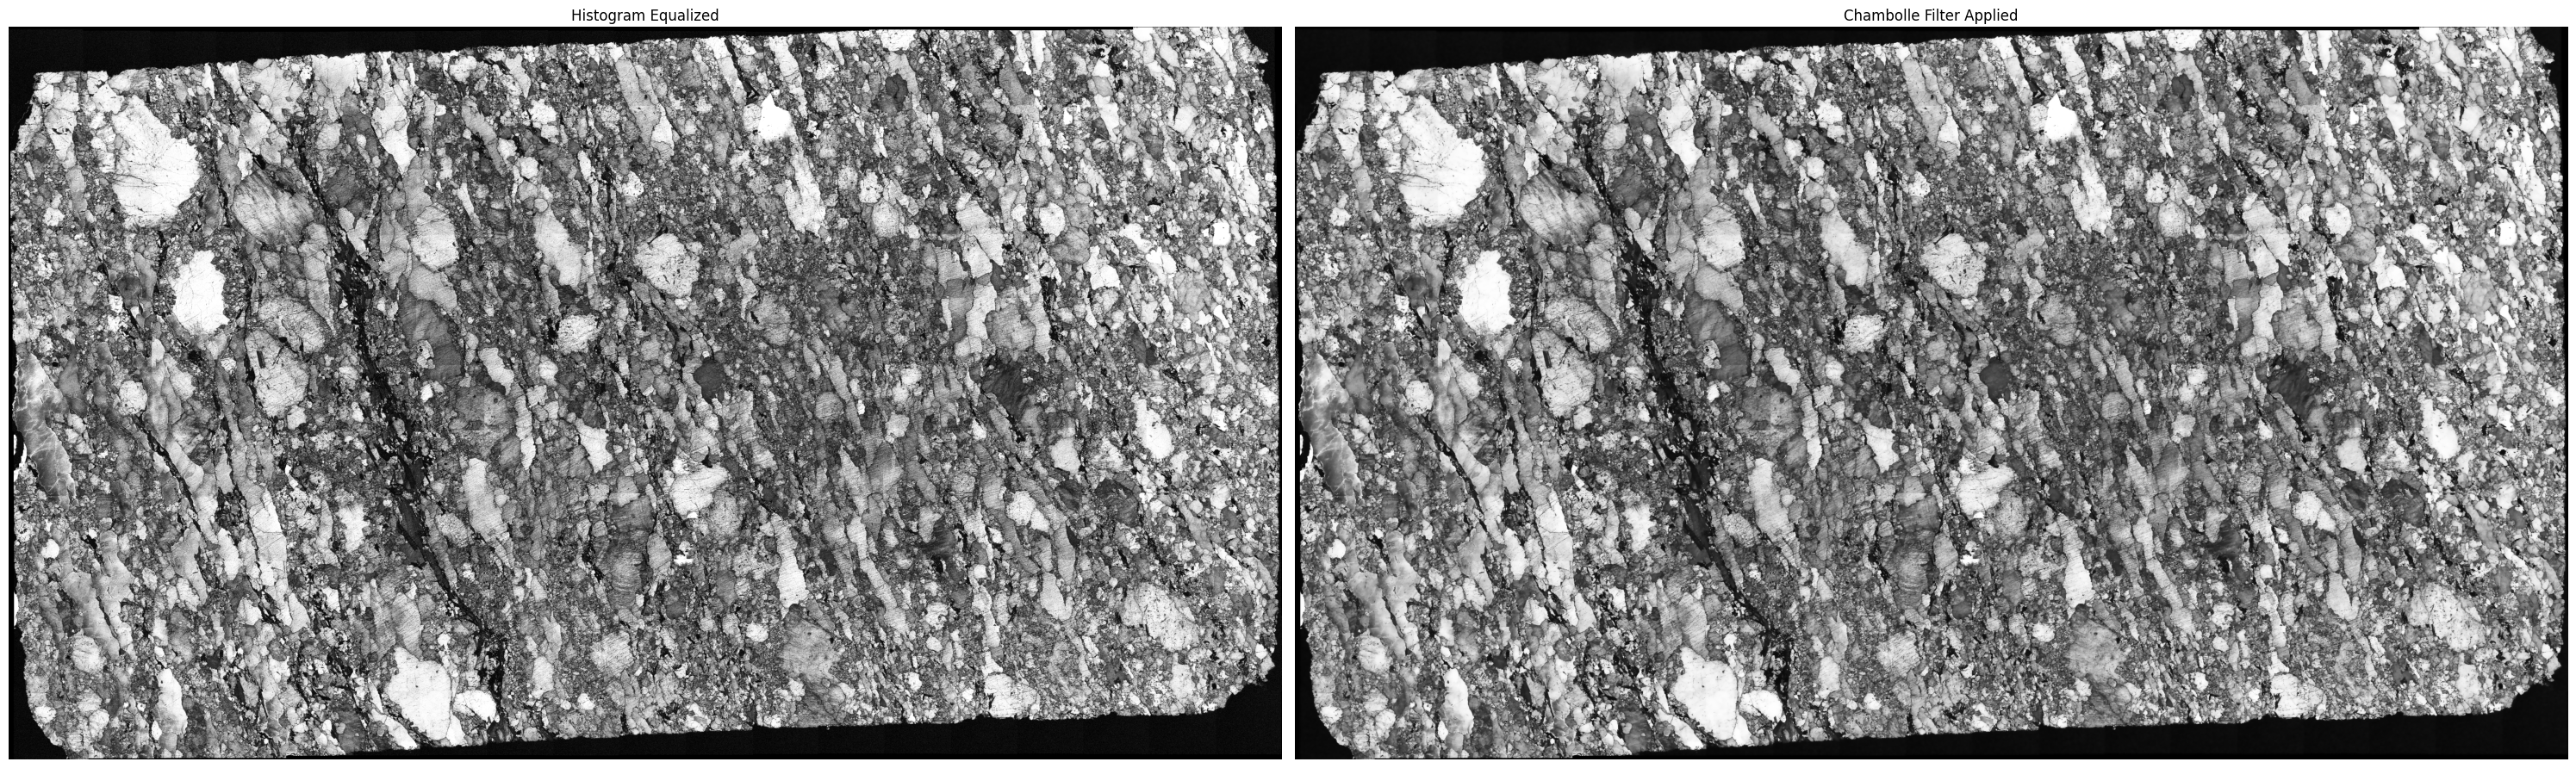

In [14]:
# Apply Chambolle denoising filter
# The weight 'alpha' parameter controls the degree of smoothing.
# alpha set to value of 0.05
chambolle_img = restoration.denoise_tv_chambolle(contrast_img, weight=0.05)

# Let's display the images
fig, axes = plt.subplots(1, 2, figsize=(30, 30))
ax = axes.ravel()

ax[0].imshow(equalized_img, cmap=plt.cm.gray)
ax[0].set_title("Histogram Equalized")

ax[1].imshow(chambolle_img, cmap=plt.cm.gray)
ax[1].set_title("Chambolle Filter Applied")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# Take original BC image and its mask and generate lists for both with numbers to match them

In [15]:
# Function to crop the images
def crop_images(original, mask, num_width, num_height, size):
    crops = []
    for i in range(num_height):
        for j in range(num_width):
            # Calculate the starting and ending indices for the crop
            start_x = j * size[0]
            start_y = i * size[1]
            end_x = start_x + size[0]
            end_y = start_y + size[1]

            # Crop the original and mask images to the same area using array slicing
            crop_original = original[start_y:end_y, start_x:end_x]
            crop_mask = mask[start_y:end_y, start_x:end_x]

            # Append the crops to the list
            crops.append({
                'original': crop_original,
                'mask': crop_mask,
                'position': (i, j)
            })

    return crops

# Crop the images
crops = crop_images(contrast_img, mask_img, n_crops_width, n_crops_height, crop_size)

# Save the cropped images to files
output_files = []
for i, crop in enumerate(crops):
    original_crop_path = f'/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/images/BC_original_crop{i}.tif'
    mask_crop_path = f'/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/masks/BC_mask_crop{i}.tif'
    io.imsave(original_crop_path, crop['original'])
    io.imsave(mask_crop_path, crop['mask'])
    output_files.append((original_crop_path, mask_crop_path))

# Return the paths of the first few cropped images for display
output_files[:5]  # Show paths of the first 5 sets of cropped images

[('/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/images/BC_original_crop0.tif',
  '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/masks/BC_mask_crop0.tif'),
 ('/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/images/BC_original_crop1.tif',
  '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/masks/BC_mask_crop1.tif'),
 ('/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/images/BC_original_crop2.tif',
  '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/masks/BC_mask_crop2.tif'),
 ('/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/images/BC_original_crop3.tif',
  '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/data/mydata/train/masks/BC_mask_crop3.tif'),
 ('/content/drive/Shared drives/Grain Detection 

# Display random pair of original cropped image and its corresponding mask

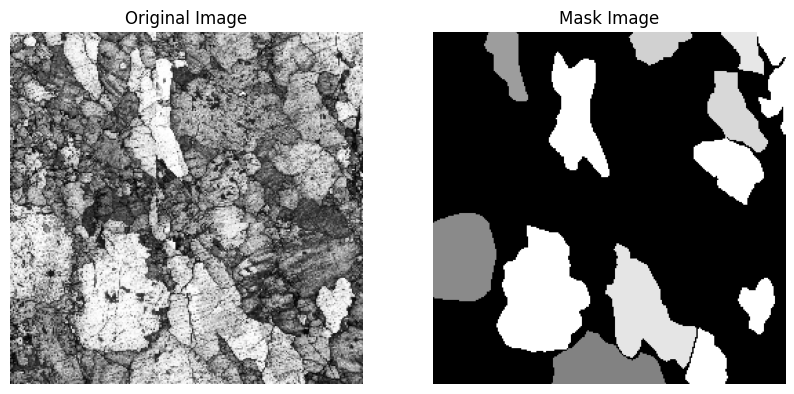

In [20]:
# Function to display a random pair of original and mask images
def random_pair(crops):

    # Randomly select one set of crops
    selected_pair = random.choice(crops)
    original_crop = selected_pair['original']
    mask_crop = selected_pair['mask']

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Display the original crop
    axes[0].imshow(original_crop, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Display the mask crop
    axes[1].imshow(mask_crop, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Mask Image')

    # Display the plot
    plt.show()

# Display a random pair
random_pair(crops)
